In [449]:
#My take on the Blackjack policy improvement using Monte Carlo Methods
import random
import numpy as np
import matplotlib.pyplot as plt

In [450]:
deck = ['A', 2, 3, 4, 5, 6, 7, 8, 9, 10, 'J', 'Q', 'K']
values = [i for i in range(4,22)]
ds = ['A', 2, 3, 4, 5, 6, 7, 8, 9, 10]
dealer_sticks = 17

In [451]:
def draw_card(deck):
    card = random.choice(deck)
    if card in ['J', 'Q', 'K']:
        card = 10
    return card

def initialize_state(deck):
    #Player hand
    h1 = draw_card(deck)
    h2 = draw_card(deck)
    
    if h1 == 'A' and h2 == 'A':
        player_sum = 12
        usable_ace = True
        
    elif h1 == 'A':
        if h2+11 <= 21:
            player_sum = h2+11
            usable_ace = True
        else: 
            player_sum = h2+1
            usable_ace = False    
    elif h2 == 'A':
        if h1+11 <= 21:
            player_sum = h1+11
            usable_ace = True
        else: 
            player_sum = h1+1
            usable_ace = False
    else:
        player_sum = h1+h2
        usable_ace = False
    
    #Dealer hand
    d1 = draw_card(deck)
    
    return usable_ace, player_sum, d1

In [452]:
class Gambler:
    def __init__(self):
        self.Q = {}
        self.N = {}
        self.policy = {}
        self.states = [(ace, player_sum, d1) for ace in [True, False] for player_sum in values for d1 in ds]  
        for s in self.states:
            if s[1]>= 20:
                self.policy[s] = 'Stand'
            else:
                self.policy[s] = 'Hit'
            for a in ['Hit', 'Stand']:
                self.Q[s, a] = 0
                self.N[s, a] = 0
                
    def show_policy(self):
        usable_ace = np.zeros([18, 10])
        no_usable_ace = np.zeros([18, 10])
        for s in self.states:
            if s[2] == 'A':
                d = 1
            else:
                d = s[2]
                
            if s[0] and self.policy[s] == 'Hit':
                usable_ace[s[1]-4, d-1] = 1
            if not s[0] and self.policy[s] == 'Hit':
                no_usable_ace[s[1]-4, d-1] = 1
                
        plt.imshow(usable_ace, origin = 'lower', extent = [1, 10, 4, 21])
        plt.figure()
        plt.imshow(no_usable_ace, origin = 'lower', extent = [1, 10, 4, 21])
        #print(usable_ace)
        
    def learn(self, r, game_record):
        for s, a in game_record:
            self.N[s, a] += 1
            self.Q[s, a] += 1/self.N[s, a]*(r-self.Q[s, a])
            
            if self.Q[s, 'Hit'] > self.Q[s, 'Stand']:
                self.policy[s] = 'Hit'
            else: self.policy[s] = 'Stand'
        
def compute_sum(new_card, hand_sum, ace):
    if new_card == 'A':
        if hand_sum+11 <= 21:
            ace = True
            hand_sum += 11
        else:
            hand_sum += 1
            
    else: hand_sum += new_card
    if hand_sum > 21 and ace:
        hand_sum -= 10
        ace = False
    return hand_sum, ace
    

In [466]:
def play_game(deck, player):
    
    starting_action = random.choice(['Hit', 'Stand'])
    game_record = [(initialize_state(deck), starting_action)]
    
    while True:
        state = game_record[-1][0]
        player_sum = state[1]
        player_action = game_record[-1][1]
            
        if player_action == 'Hit':
            card = draw_card(deck)
            player_sum, usable_ace = compute_sum(card, player_sum, state[0])
            new_state = (usable_ace, player_sum, state[2])
            if player_sum > 21:
                return -1, game_record
            game_record.append((new_state, player.policy[new_state]))
        else:
            dealer_card = state[2]
            if dealer_card == 'A':
                dealer_sum = 11
                dealer_ace = True
            else: 
                dealer_sum = dealer_card
                dealer_ace = False
            while True:
                card = draw_card(deck)
                dealer_sum, dealer_ace = compute_sum(card, dealer_sum, dealer_ace)
                if dealer_sum > 21:
                    return 1, game_record
                elif dealer_sum >= dealer_sticks:
                    if dealer_sum > player_sum:
                        return -1, game_record
                    elif dealer_sum == player_sum:
                        return 0, game_record
                    return 1, game_record

In [467]:
player = Gambler()

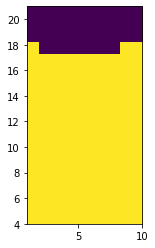

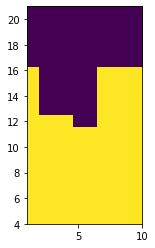

In [468]:
num_games = 10000000
for i in range(num_games+1):
    r, game_record = play_game(deck, player)
    player.learn(r, game_record)
    
player.show_policy()

In [469]:
def play_full_game(deck, player):
    
    state = initialize_state(deck)
    starting_action = player.policy[state]
    game_record = [(state, starting_action)]
    
    while True:
        state = game_record[-1][0]
        player_sum = state[1]
        player_action = game_record[-1][1]
        
        if player_action == 'Hit':
            card = draw_card(deck)
            player_sum, usable_ace = compute_sum(card, player_sum, state[0])
            new_state = (usable_ace, player_sum, state[2])
            if player_sum > 21:
                return -1, game_record
            game_record.append((new_state, player.policy[new_state]))
        else:
            dealer_card = state[2]
            if dealer_card == 'A':
                dealer_sum = 11
                dealer_ace = True
            else: 
                dealer_sum = dealer_card
                dealer_ace = False
            while True:
                card = draw_card(deck)
                dealer_sum, dealer_ace = compute_sum(card, dealer_sum, dealer_ace)
                if dealer_sum > 21:
                    return 1, game_record
                elif dealer_sum >= dealer_sticks:
                    if dealer_sum > player_sum:
                        return -1, game_record
                    elif dealer_sum == player_sum:
                        return 0, game_record
                    return 1, game_record

In [471]:
num_games = 100000
total_money = 0

for i in range(num_games):
    r, game_record = play_full_game(deck, player)
    total_money += r

print('The player ended up with', total_money, 'total money.')
print('The expected value is', 100*total_money/num_games,'%')

The player ended up with -4686 total money.
The expected value is -4.686 %
